# Arbol de Decisión:

En este notebook, exploraremos cómo utilizar árboles de decisión para predecir el éxito de las canciones en las listas de Billboard. Utilizaremos un conjunto de datos que contiene información sobre diferentes características de las canciones, como el estado de ánimo, el tempo, el género, el tipo de artista, la edad y la duración. Nuestro objetivo será entrenar un modelo de árbol de decisión capaz de predecir si una canción llegará al puesto número 1 en las listas de Billboard

In [ ]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cargamos los datos de entrada

In [ ]:
import pandas as pd


# Read the CSV file into a DataFrame
data = pd.read_csv("/content/data.csv")




Antes de entrenar el modelo, exploraremos los datos y realizaremos algunas tareas de preprocesamiento. Analizaremos la distribución de las características, trataremos los valores faltantes y codificaremos las variables categóricas para que puedan ser utilizadas en el modelo de árbol de decisión.

In [ ]:
data.shape

(635, 11)

In [ ]:
data.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


## ¿Cuántos alcanzaron el número 1?

In [ ]:
data.groupby('top').size()

top
0    494
1    141
dtype: int64

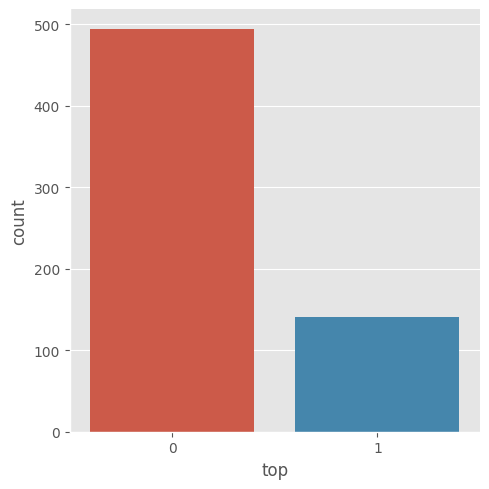

In [ ]:
import seaborn as sns

sns.catplot(x='top', data=data, kind='count')

## Visualicemos los Atributos de entrada

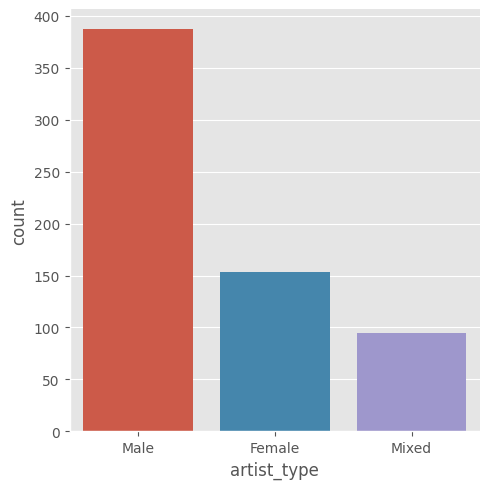

In [ ]:

sns.catplot(x='artist_type', data=data, kind='count')


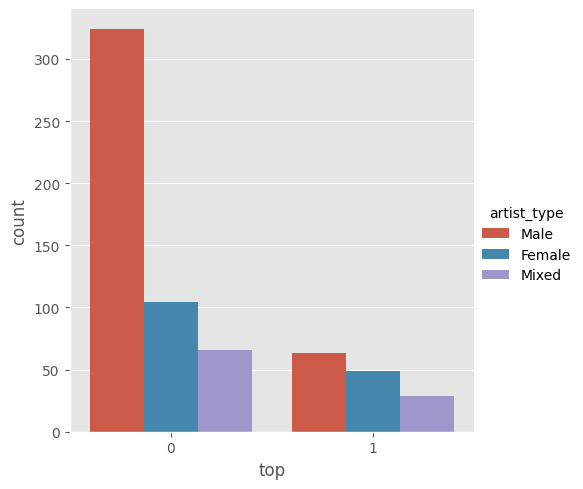

In [ ]:
sns.catplot(x='top', data=data, hue='artist_type', kind='count')

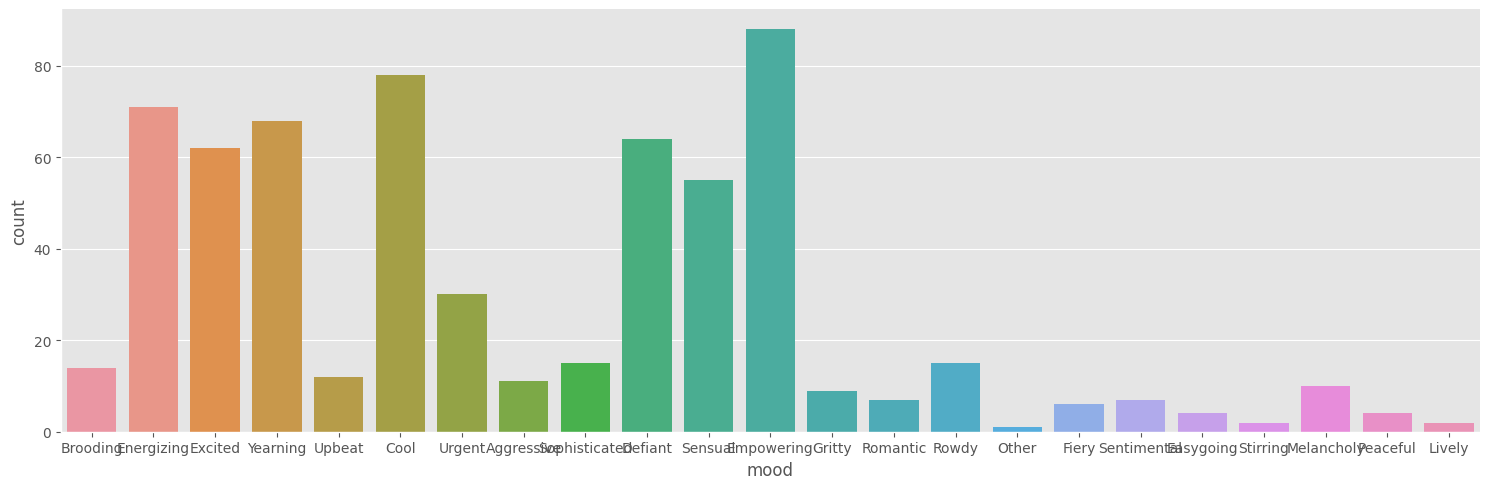

In [ ]:
sns.catplot(x='mood', data=data, kind='count', aspect=3)

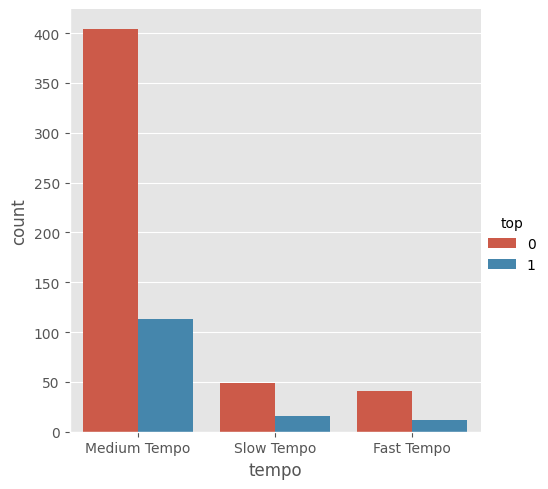

In [ ]:
sns.catplot(x='tempo', data=data, hue='top', kind='count')


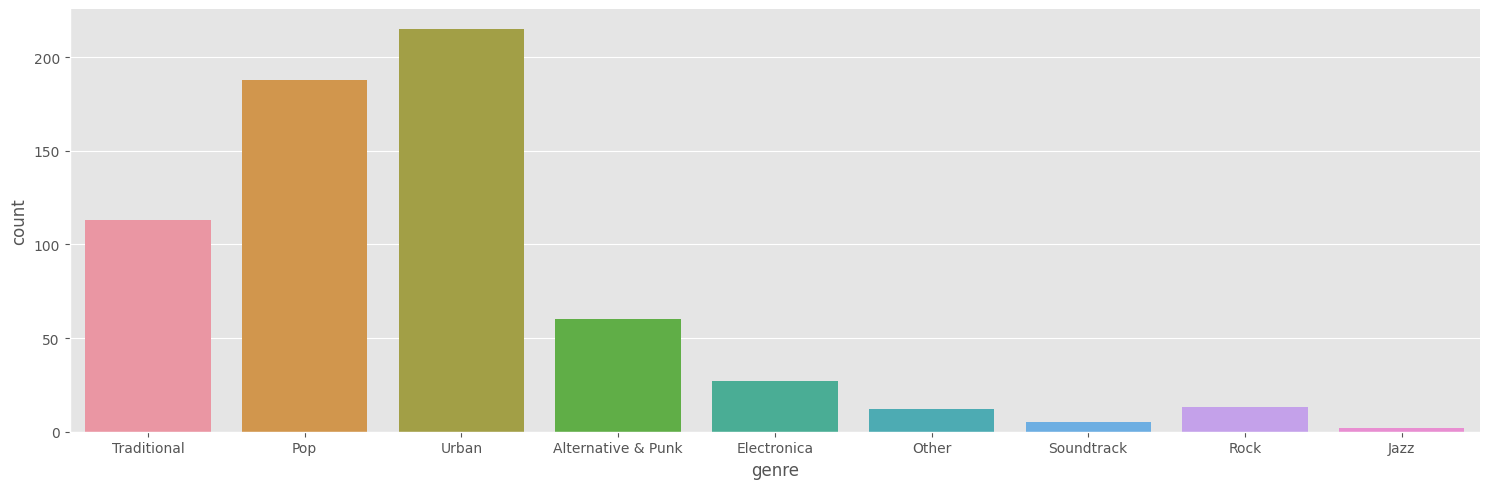

In [ ]:

sns.catplot(x='genre', data=data, kind='count', aspect=3)

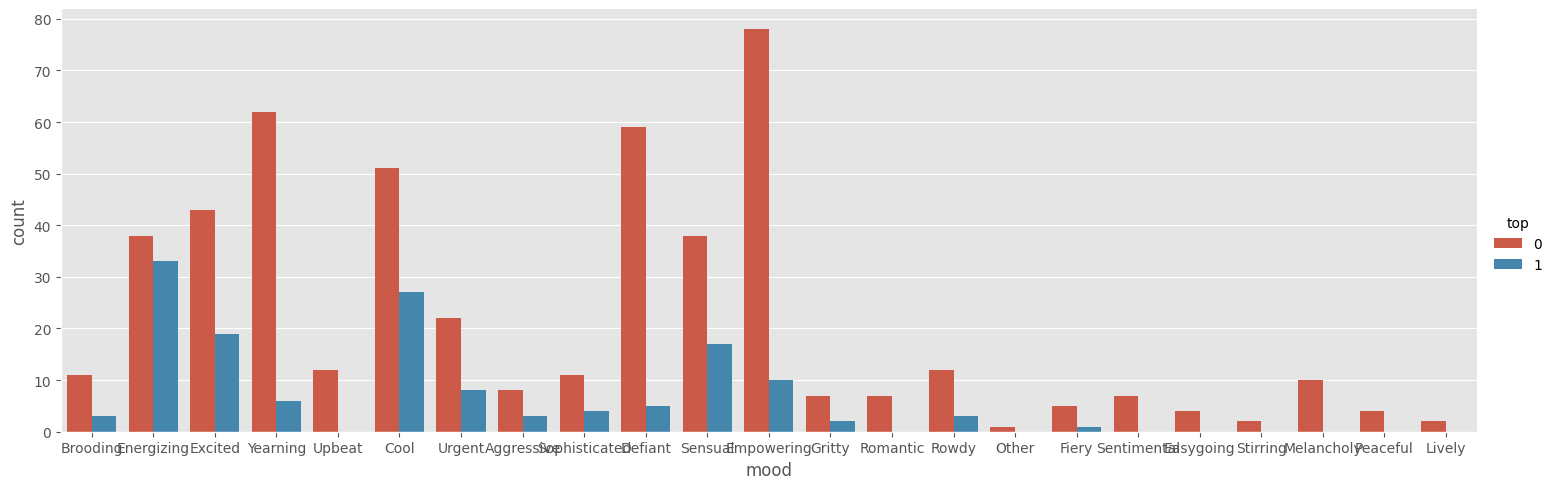

In [ ]:

sns.catplot(x='mood', data=data, hue='top', kind='count', aspect=3)

### Visualizamos los años de nacimiento de los artistas

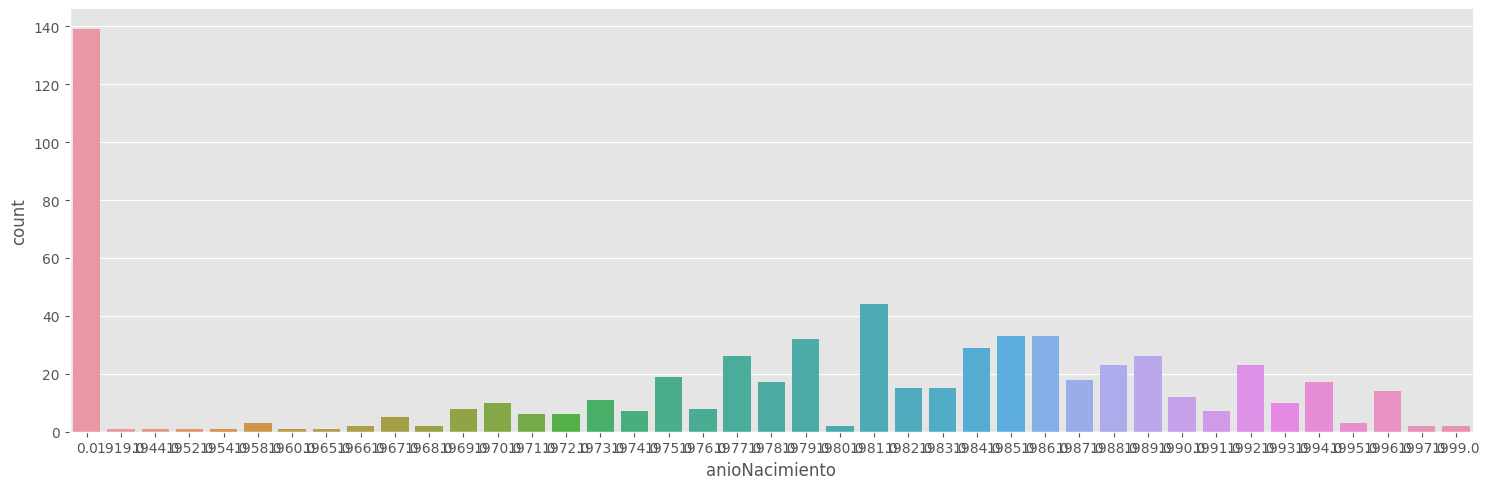

In [ ]:
sns.catplot(x='anioNacimiento', data=data, kind='count', aspect=3)

In [ ]:

nacimientosPorAnio = data['anioNacimiento']
len(nacimientosPorAnio[nacimientosPorAnio<=0])

139

Notamos que tenemos 139 registros de canciones de las que desconocemos el año de nacimiento del artista. Deberemos tratar estos datos para poder utilizar el árbol.

## Arreglar las Edades de Artistas

In [ ]:
import pandas as pd

# Calcula la mediana de la columna 'anioNacimiento'
mediana = data['anioNacimiento'].median()

# Asigna la mediana a los valores faltantes en 'anioNacimiento'
data['anioNacimiento'].fillna(mediana, inplace=True)


# Mapeo de Atributos

Realizaremos un mapeo de los atributos de entrada para poder transformarlos a categorias que podamos utilzar en nuestro árbol de decisión

In [ ]:
separador = "### ### ###"
grouped11 = data.groupby('mood').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)
print(separador)
print("Tempos de Canción: " + str(data['tempo'].unique()))
print(separador)
print("Tipos de Artista: " + str(data['artist_type'].unique()))
print(separador)
grouped11 = data.groupby('genre').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)

mood
Empowering       88
Cool             78
Energizing       71
Yearning         68
Defiant          64
Excited          62
Sensual          55
Urgent           30
Rowdy            15
Sophisticated    15
Brooding         14
Upbeat           12
Aggressive       11
Melancholy       10
Gritty            9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64
### ### ###
Tempos de Canción: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo']
### ### ###
Tipos de Artista: ['Male' 'Female' 'Mixed']
### ### ###
genre
Urban                 215
Pop                   188
Traditional           113
Alternative & Punk     60
Electronica            27
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64



`grouped11` = data.groupby('mood').size(): Este código agrupa el conjunto de datos 'data' por la columna 'mood' y cuenta la cantidad de registros en cada grupo. Esto proporciona una vista de resumen de cuántas canciones hay para cada estado de ánimo.

`neworder11` = grouped11.sort_values(ascending=False): Aquí se ordena la vista de resumen de los estados de ánimo en orden descendente, para que los estados de ánimo más comunes aparezcan primero. Esto es útil para comprender la distribución de los estados de ánimo en los datos.


`grouped11` = data.groupby('genre').size(): Similar al paso 1, este código agrupa el conjunto de datos 'data' por la columna 'genre' y cuenta la cantidad de registros en cada grupo. Proporciona una vista de resumen de cuántas canciones hay para cada género musical.

`neworder11` = grouped11.sort_values(ascending=False): Ordena la vista de resumen de los géneros musicales en orden descendente, para mostrar los géneros más comunes primero.

Este código te brinda información sobre la distribución de los estados de ánimo, los tempos, los tipos de artistas y los géneros musicales presentes en el conjunto de datos 'data'. Esto puede ser útil para comprender las características de los datos y decidir cómo mapear o transformar esas características en categorías adecuadas para utilizar en un árbol de decisión.

* Tempos de Canción: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo']

Esta línea muestra los diferentes tempos de las canciones presentes en los datos. Los tempos identificados son: 'Medium Tempo', 'Slow Tempo' y 'Fast Tempo'. Estos valores indican la velocidad o el ritmo de las canciones en el conjunto de datos.
* Tipos de Artista: ['Male' 'Female' 'Mixed']

Esta línea muestra los diferentes tipos de artistas presentes en los datos. Los tipos de artistas identificados son: 'Male' (masculino), 'Female' (femenino) y 'Mixed' (mezclado). Estos valores indican el género o la composición de los artistas involucrados en las canciones del conjunto de datos.

Distribución de los géneros musicales:

-Urban: 215 canciones
-Pop: 188 canciones
-Traditional: 113 canciones
-Alternative & Punk: 60 canciones
-Electronica: 27 canciones
-Rock: 13 canciones
-Other: 12 canciones
-Soundtrack: 5 canciones
-Jazz: 2 canciones
Estos resultados brindan una visión general de la distribución de los géneros musicales en el conjunto de datos. Puedes utilizar esta información para comprender cuáles son los géneros más representados y cuáles son menos comunes en los datos utilizados para el análisis.








In [ ]:
# Mood Mapping
data['moodEncoded'] = data['mood'].map( {'Energizing': 6,
                                        'Empowering': 6,
                                        'Cool': 5,
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3,
                                        'Sensual': 2,
                                        'Gritty': 3, #coraje
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3,
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4,
                                        'Romantic': 2,
                                        'Peaceful': 1,
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping
data['tempoEncoded'] = data['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping
data['genreEncoded'] = data['genre'].map( {'Urban': 4,
                                          'Pop': 3,
                                          'Traditional': 2,
                                          'Alternative & Punk': 1,
                                         'Electronica': 1,
                                          'Rock': 1,
                                          'Soundtrack': 0,
                                          'Jazz': 0,
                                          'Other':0,'':0}
                                       ).astype(int)
# artist_type Mapping
data['artist_typeEncoded'] = data['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)




# Mapping Song Duration
data.loc[ data['durationSeg'] <= 150, 'durationEncoded'] 					       = 0
data.loc[(data['durationSeg'] > 150) & (data['durationSeg'] <= 180), 'durationEncoded'] = 1
data.loc[(data['durationSeg'] > 180) & (data['durationSeg'] <= 210), 'durationEncoded'] = 2
data.loc[(data['durationSeg'] > 210) & (data['durationSeg'] <= 240), 'durationEncoded'] = 3
data.loc[(data['durationSeg'] > 240) & (data['durationSeg'] <= 270), 'durationEncoded'] = 4
data.loc[(data['durationSeg'] > 270) & (data['durationSeg'] <= 300), 'durationEncoded'] = 5
data.loc[ data['durationSeg'] > 300, 'durationEncoded'] = 6

* Mood Mapping:

Se mapean diferentes estados de ánimo de las canciones a valores numéricos del 0 al 6. Cada estado de ánimo tiene asignado un valor numérico que representa su nivel de energía o intensidad.
* Tempo Mapping:

Se mapean los diferentes tempos de las canciones a valores numéricos del 0 al 2. Cada tempo tiene asignado un valor numérico que indica la velocidad o ritmo de la canción.
* Genre Mapping:

Se mapean los diferentes géneros musicales a valores numéricos del 0 al 4. Cada género tiene asignado un valor numérico que representa su categoría dentro del conjunto de datos.
* Artist Type Mapping:

Se mapean los diferentes tipos de artistas a valores numéricos del 0 al 3. Cada tipo de artista tiene asignado un valor numérico que indica su género o composición.
* Song Duration Mapping:

Se mapea la duración de las canciones a valores numéricos del 0 al 6. Cada rango de duración tiene asignado un valor numérico que representa una categoría de duración específica.

In [ ]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg']
artists_encoded = data.drop(drop_elements, axis = 1)

# Analizamos nuestros datos de Entrada Categóricos

Recordemos: Los datos categóricos son variables que representan diferentes categorías o grupos. Estas variables no tienen un orden inherente o numérico, sino que representan características cualitativas o atributos distintos. Los datos categóricos se dividen en dos tipos principales: variables nominales y variables ordinales.

* Variables nominales: Las variables nominales son categorías sin ningún orden o jerarquía específica. Estas categorías representan diferentes grupos o clases, pero no hay una relación de orden entre ellas. Ejemplos de variables nominales incluyen el género (masculino, femenino, otros), el color (rojo, verde, azul) o la raza (blanco, negro, asiático).

* Variables ordinales: Las variables ordinales también representan categorías, pero tienen un orden o jerarquía específica entre ellas. Estas categorías reflejan diferentes niveles o grados de una característica particular. Ejemplos de variables ordinales incluyen las calificaciones de satisfacción (muy insatisfecho, insatisfecho, neutral, satisfecho, muy satisfecho) o los niveles educativos (primaria, secundaria, bachillerato, licenciatura, posgrado).

In [ ]:
artists_encoded.head()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,durationEncoded
0,0,4,2,2,3,2.0
1,0,6,2,3,2,6.0
2,1,5,2,4,1,3.0
3,0,4,2,1,3,2.0
4,0,4,2,2,2,3.0


In [ ]:
artists_encoded.describe()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,durationEncoded
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.222047,4.344882,1.730709,2.755906,2.459843,3.179528
std,0.415950,1.350003,0.603553,1.165463,0.740583,1.775017
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,3.000000,2.000000,2.000000,2.000000,2.000000
50%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000
75%,0.000000,5.500000,2.000000,4.000000,3.000000,4.000000
max,1.000000,6.000000,2.000000,4.000000,3.000000,6.000000


<Axes: title={'center': 'Pearson Correlation of Features'}>

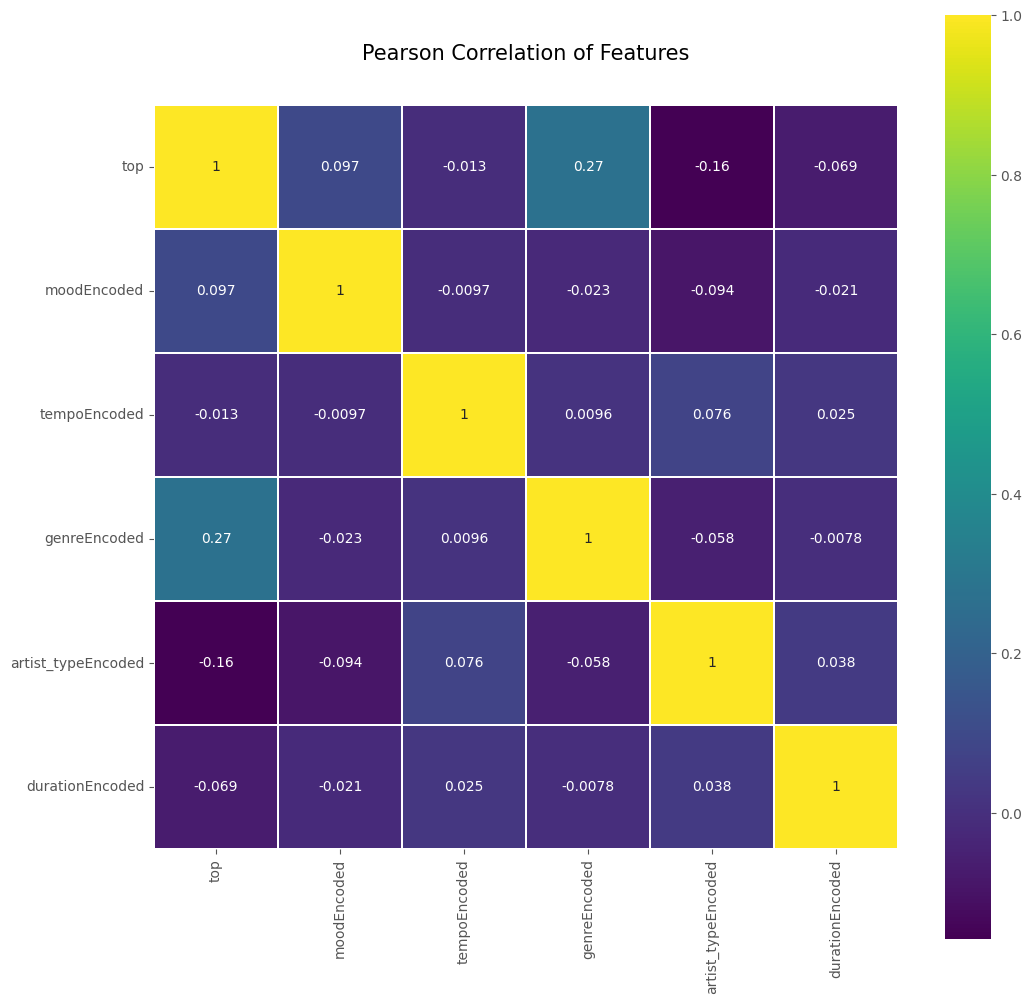

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(artists_encoded.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


* Identificar variables correlacionadas: La correlación de Pearson ayuda a identificar qué características del conjunto de datos están altamente correlacionadas entre sí. Una correlación alta (cercana a 1 o -1) indica una relación lineal fuerte, lo que significa que los cambios en una variable están asociados con cambios en la otra variable.

* Determinar la dirección de la correlación: La correlación de Pearson indica si la relación entre dos variables es positiva o negativa. Una correlación positiva (cerca de 1) significa que a medida que aumenta el valor de una variable, también tiende a aumentar el valor de la otra variable. Una correlación negativa (cerca de -1) significa que a medida que aumenta el valor de una variable, tiende a disminuir el valor de la otra variable.

* Evaluar la fuerza de la correlación: El valor numérico de la correlación de Pearson indica la fuerza de la relación lineal entre dos variables. Cuanto más cercano esté el valor a 1 o -1, más fuerte será la correlación. Un valor cercano a 0 indica una correlación débil o nula.

* Identificar relaciones no lineales: Aunque la correlación de Pearson se utiliza para medir la relación lineal, también puede proporcionar indicios sobre relaciones no lineales entre variables. Si la correlación de Pearson es cercana a 0 pero existe una relación no lineal, es posible que se requieran técnicas adicionales para analizar y modelar la relación entre las variables.

In [ ]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

El código calcula las estadísticas (media, recuento y suma) de la variable 'top' para cada valor único de 'moodEncoded' en el DataFrame 'artists_encoded'. Esto puede proporcionar información sobre cómo la variable 'top' se distribuye en diferentes categorías de 'moodEncoded'.

In [ ]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

In [ ]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

In [ ]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

In [ ]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

# Buscamos nuestro Arbol de Decisión

El código proporcionado realiza una validación cruzada (cross-validation) para evaluar la precisión media de un modelo de árbol de decisión en función de la profundidad máxima del árbol.

In [ ]:
cv = KFold(n_splits=10)

Se crea un objeto KFold para realizar la validación cruzada con 10 "folds" (divisiones) del conjunto de datos. Esto significa que se dividirá el conjunto de datos en 10 partes, y se realizarán 10 iteraciones del proceso de entrenamiento y evaluació

In [ ]:
 # Numero deseado de "folds" que haremos
accuracies = []
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)




Se crean listas vacías para almacenar las precisiones obtenidas en cada iteración de validación cruzada. Se calcula el número máximo de atributos en el DataFrame 'artists_encoded' y se crea un rango de profundidades desde 1 hasta el número máximo de atributos. Esto se utilizará para iterar sobre diferentes profundidades del árbol de decisión.

In [ ]:
# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})

Se inicia un bucle que iterará sobre las diferentes profundidades del árbol de decisión. En cada iteración, se crea un modelo de árbol de decisión con los parámetros especificados, incluida la profundidad actual.

In [ ]:
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold]
        f_valid = artists_encoded.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['top'], axis=1),
                               y = f_train["top"])
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1),
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)



Dentro de cada iteración de validación cruzada, se divide el conjunto de datos en un conjunto de entrenamiento (train_fold) y un conjunto de validación (valid_fold) utilizando el objeto KFold. Se entrena el modelo de árbol de decisión con el conjunto de entrenamiento y se evalúa su precisión en el conjunto de validación. La precisión se almacena en la lista fold_accuracy.

In [ ]:
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)



Se calcula el promedio de las precisiones obtenidas en cada "fold" de validación cruzada y se agrega a la lista accuracies.

# Creamos el Arbol de Decisión

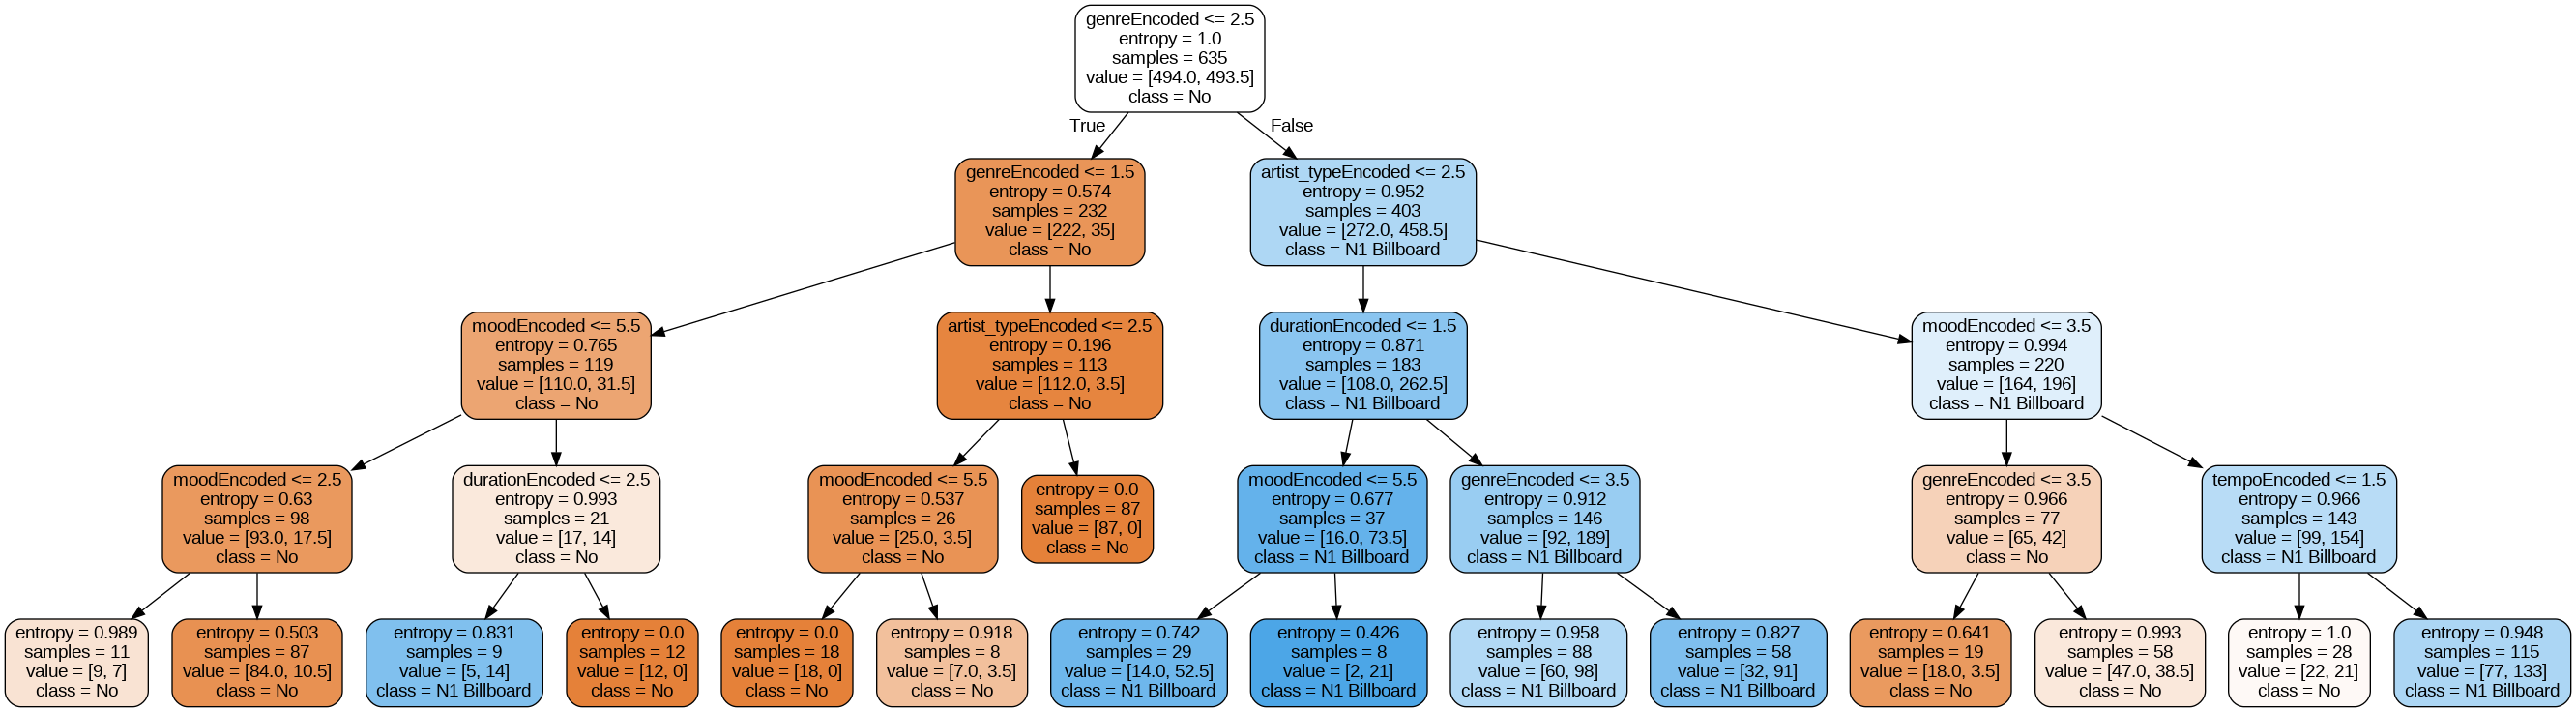

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

Se crea dos arrays: `y_train`, que contiene las etiquetas que indican si una canción llegó al top o no, y `x_train`, que contiene los atributos de entrenamiento después de eliminar la columna 'top'.

Crea un árbol de decisión utilizando la clase `DecisionTreeClassifier` de scikit-learn. Se configuran los parámetros del árbol, como el criterio de división ('`entropy`'), el número mínimo de muestras requeridas para dividir un nodo interno (20), el número mínimo de muestras requeridas en cada hoja final (5) y la profundidad máxima del árbol (4).

Se ajusta el modelo de árbol de decisión utilizando los datos de entrenamiento (`x_train` y `y_train`).

Exporta el modelo de árbol de decisión a un archivo .dot utilizando la función `export_graphviz`. Se especifica la profundidad máxima del árbol (7), se incluye la impureza de los nodos en el archivo .dot, se proporcionan los nombres de las características y las clases, y se establecen otras opciones de visualización.
Convierte el archivo .dot a un archivo de imagen .png utilizando la biblioteca `Graphviz` y la función `check_call`.

Muestra la imagen del árbol de decisión utilizando la biblioteca PIL y la clase PImage.

## Precisión del árbol

In [ ]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

66.3


# Predicción del árbol de decisión

In [ ]:
x_test = pd.DataFrame(columns=('moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','durationEncoded'))
x_test.loc[0] = (5, 2, 4, 1, 3)

y_pred = decision_tree.predict(x_test)
print("Predicción: " + str(y_pred))

y_proba = decision_tree.predict_proba(x_test)
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0] * 100, 2)) + "%")


Predicción: [1]
Probabilidad de Acierto: 73.98%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


La probabilidad de acierto obtenida para la predicción realizada es del 73.98%. Esto significa que, según el modelo de árbol de decisión entrenado, hay una probabilidad del 73.98% de que la canción analizada llegue al top.

El árbol de decisión se ajustó con una profundidad máxima de 4 niveles, y se utilizó la medida de entropía como criterio para tomar las decisiones en cada nodo. Además, se aplicaron restricciones en la división de muestras mínimas y en el número mínimo de muestras requeridas en cada hoja.

Se evaluó la precisión del modelo utilizando validación cruzada con 10 "folds" y se obtuvo la precisión promedio para diferentes profundidades del árbol. Los resultados mostraron que a medida que se incrementa la profundidad del árbol, la precisión tiende a aumentar hasta alcanzar un máximo.

Finalmente, se exportó el árbol de decisión entrenado a un archivo .dot y se generó una representación gráfica en formato PNG para visualizar la estructura del árbol.

En base a las predicciones realizadas utilizando el árbol de decisión entrenado, se pudo determinar la probabilidad de que una canción específica llegue al top. En este caso particular, la canción evaluada obtuvo una probabilidad de acierto del 73.98%.

En conclusión, el uso de un modelo de árbol de decisión aplicado a los datos de Billboard permitió obtener predicciones sobre el rendimiento de una canción en los rankings.